### Let' try using notebooks!

OK, so I decided to try out using notebooks for my journal. Just as a proof of concept, I'll attempt to replicate my last note here.

#### Results

I implemented a basic framework to model people's actions, and I managed to implement 3 distinct "strategies" that people can take - constant selfishness, constant anti-selfishness and strategic selfishness. Constant anti-selfishness was there just to make sure everything works, so I compared constant selfishness with strategic selfishness.

In [1]:
import datetime
import pathlib
import random

import matplotlib
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import pandas as pd

from orgsim import common, framework, models
%matplotlib inline
plt.ioff()

In [2]:
class Plotter:
    def __init__(self, metrics: models.metrics.Metrics) -> None:
        self._metrics = metrics

    def _build_individual_wealth(self, ax: matplotlib.axes.Axes) -> None:
        min_ = self._metrics.get_fiscal_series("min_wealth")
        avg = self._metrics.get_fiscal_series("avg_wealth")
        max_ = self._metrics.get_fiscal_series("max_wealth")

        ax.plot(max_.index, max_, label="max")
        ax.plot(avg.index, avg, label="avg")
        ax.plot(min_.index, min_, label="min")
        ax.set_ylabel("Individual Wealth")
        ax.set_xlabel("Period")
        ax.legend()
        ax.set_yscale("log")
        ax.set_ylim(1e0, 1e8)

    def _build_selfishness(self, ax: matplotlib.axes.Axes) -> None:
        min_ = self._metrics.get_fiscal_series("min_selfishness")
        avg = self._metrics.get_fiscal_series("avg_selfishness")
        max_ = self._metrics.get_fiscal_series("max_selfishness")

        ax.plot(max_.index, max_, label="max")
        ax.plot(avg.index, avg, label="avg")
        ax.plot(min_.index, min_, label="min")
        ax.set_ylabel("Selfishness")
        ax.set_xlabel("Period")
        ax.legend()
        ax.set_ylim(-0.1, 1.1)

    def _build_contribution(self, ax: matplotlib.axes.Axes) -> None:
        min_ = self._metrics.get_fiscal_series("min_contribution")
        avg = self._metrics.get_fiscal_series("avg_contribution")
        max_ = self._metrics.get_fiscal_series("max_contribution")

        ax.plot(max_.index, max_, label="max")
        ax.plot(avg.index, avg, label="avg")
        ax.plot(min_.index, min_, label="min")
        ax.set_ylabel("Contribution")
        ax.set_xlabel("Period")
        ax.legend()
        ax.set_ylim(0, 365)

    def _build_age(self, ax: matplotlib.axes.Axes) -> None:
        min_ = self._metrics.get_fiscal_series("min_age") / 365
        avg = self._metrics.get_fiscal_series("avg_age") / 365
        max_ = self._metrics.get_fiscal_series("max_age") / 365

        ax.plot(max_.index, max_, label="max")
        ax.plot(avg.index, avg, label="avg")
        ax.plot(min_.index, min_, label="min")
        ax.set_ylabel("Age")
        ax.set_xlabel("Period")
        ax.legend()
        ax.set_ylim(0, 21)

    def _build_age_distribution(self, ax: matplotlib.axes.Axes) -> None:
        series = list(self._metrics.get_series_in_class("person_age"))
        for v, labels_ in series:
            v["identity"] = int(labels_["identity"])
        df = pd.concat([s[0] for s in series]).groupby("identity")["value"].max() / 365
        ax.hist(df, bins=list(range(0, 21, 2)))
        ax.set_xlim(0, 20)

    def build(self) -> matplotlib.figure.Figure:
        fig, axs = plt.subplots(3, 2, figsize=(18, 10))
        self._build_individual_wealth(axs[0][0])
        self._build_contribution(axs[2][0])
        self._build_selfishness(axs[1][0])
        self._build_age(axs[1][1])
        self._build_age_distribution(axs[2][1])

        population = self._metrics.get_fiscal_series("population")
        axs[0][1].plot(population.index, population)
        axs[0][1].set_ylim(0, 50)

        return fig


def record_run(title: str, seed: framework.WorldSeed, metrics: models.metrics.Metrics) -> None:
    root = pathlib.Path(".", title)
    root.mkdir(parents=True, exist_ok=True)

    with open(f"{root}/seed.json", mode="w") as f:
        f.write(seed.model_dump_json())

    with open(f"{root}/metrics.json", mode="w") as f:
        f.write(metrics.data.model_dump_json())

def run_experiment(title: str, seed: framework.WorldSeed, strategy: framework.WorldStrategy):
    w = framework.create_world(
        seed=world_seed,
        strategy=strategy,
    )
    
    for i in range(int(2e2)):
        w.run_period()
        if i % 10 == 0:
            print("Period", i)
        if w.is_empty():
            break
    
    record_run(title, world_seed, strategy.metrics)

def plot_run(title: str) -> None:
    metrics = None
    with open(f"{title}/metrics.json") as f:
        data = models.metrics.MetricsData.model_validate_json(f.read())
        metrics = models.metrics.Metrics(data)
    fig = Plotter(metrics).build()
    return fig

In [3]:
fiscal_length = 365
id_gen = common.SequentialIdentityGenerator()
recruitment_strategy = models.recruitment.AverageOfTopContributors(
    identity_generator=id_gen, percentile=0.1
)
world_seed = framework.WorldSeed(
    initial_people={
        framework.PersonSeed(
            identity=id_gen.generate(), selfishness=random.random()
        )
        for _ in range(10)
    },
    fiscal_length=fiscal_length,
    productivity=1.0,
    initial_individual_wealth=600_000,
    daily_salary=300_000 / 365,
    daily_living_cost=600_000 / 365,
    periodic_recruit_count=1,
    max_age=fiscal_length * 20,
)

##### Constant selfishness

Period 0
Period 10
Period 20
Period 30
Period 40
Period 50
Period 60
Period 70
Period 80
Period 90
Period 100
Period 110
Period 120
Period 130
Period 140
Period 150
Period 160
Period 170
Period 180
Period 190


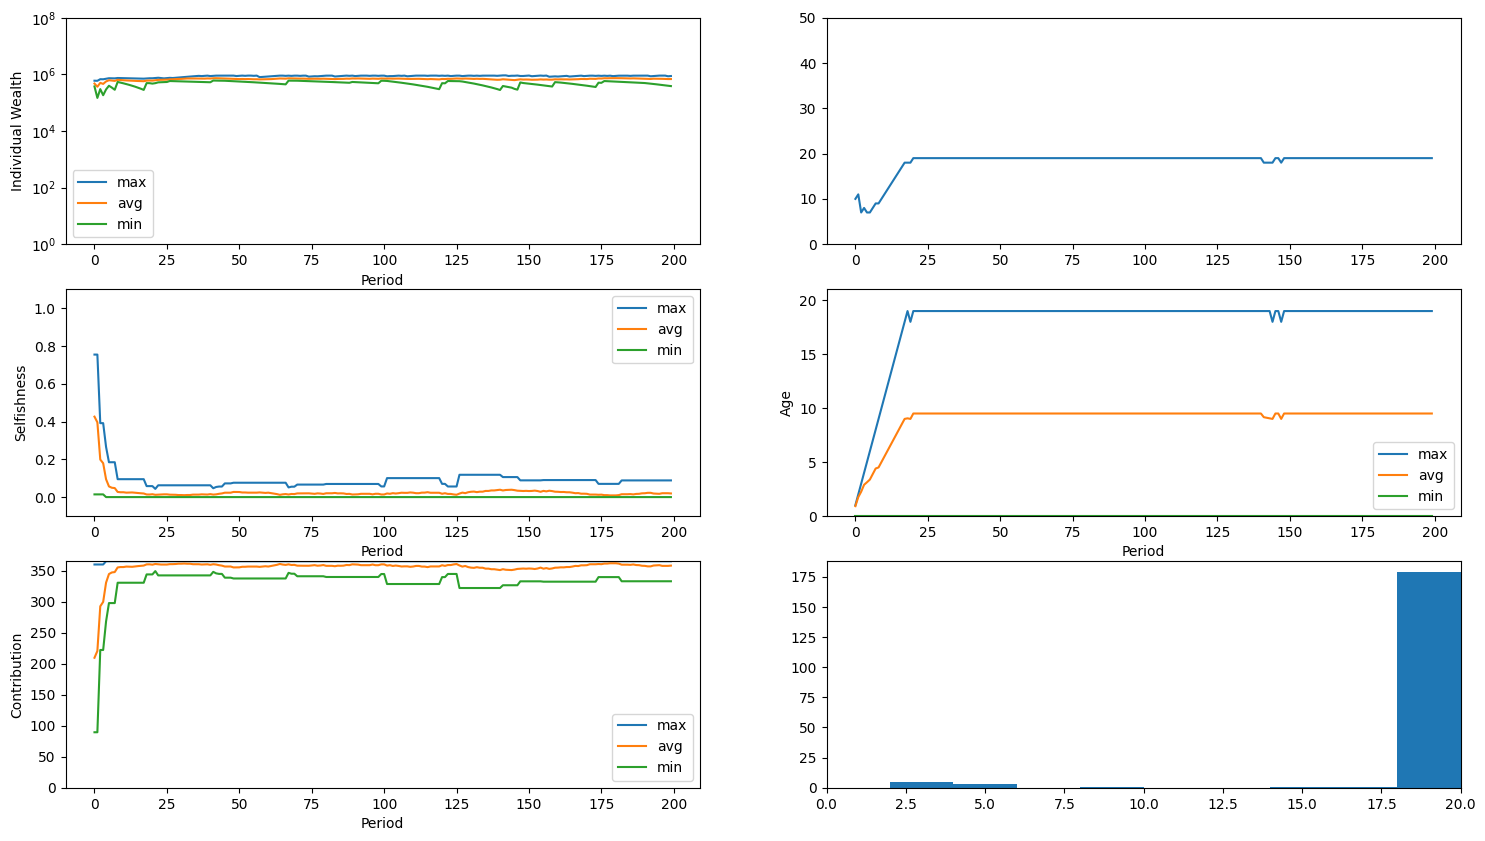

In [4]:
strategy = models.DefaultWorldStrategy(
    reward_distribution_strategy=models.EqualContribution(),
    recruitment_strategy=recruitment_strategy,
    person_action_strategy=models.person.ConstantSelfishness(),
    identity_generator=id_gen,
)
run_experiment('constant-selfishness', world_seed, strategy)
plot_run('constant-selfishness')

##### Strategic Selfishness

Period 0
Period 10
Period 20
Period 30
Period 40
Period 50
Period 60
Period 70
Period 80
Period 90
Period 100
Period 110
Period 120
Period 130
Period 140
Period 150
Period 160
Period 170
Period 180
Period 190


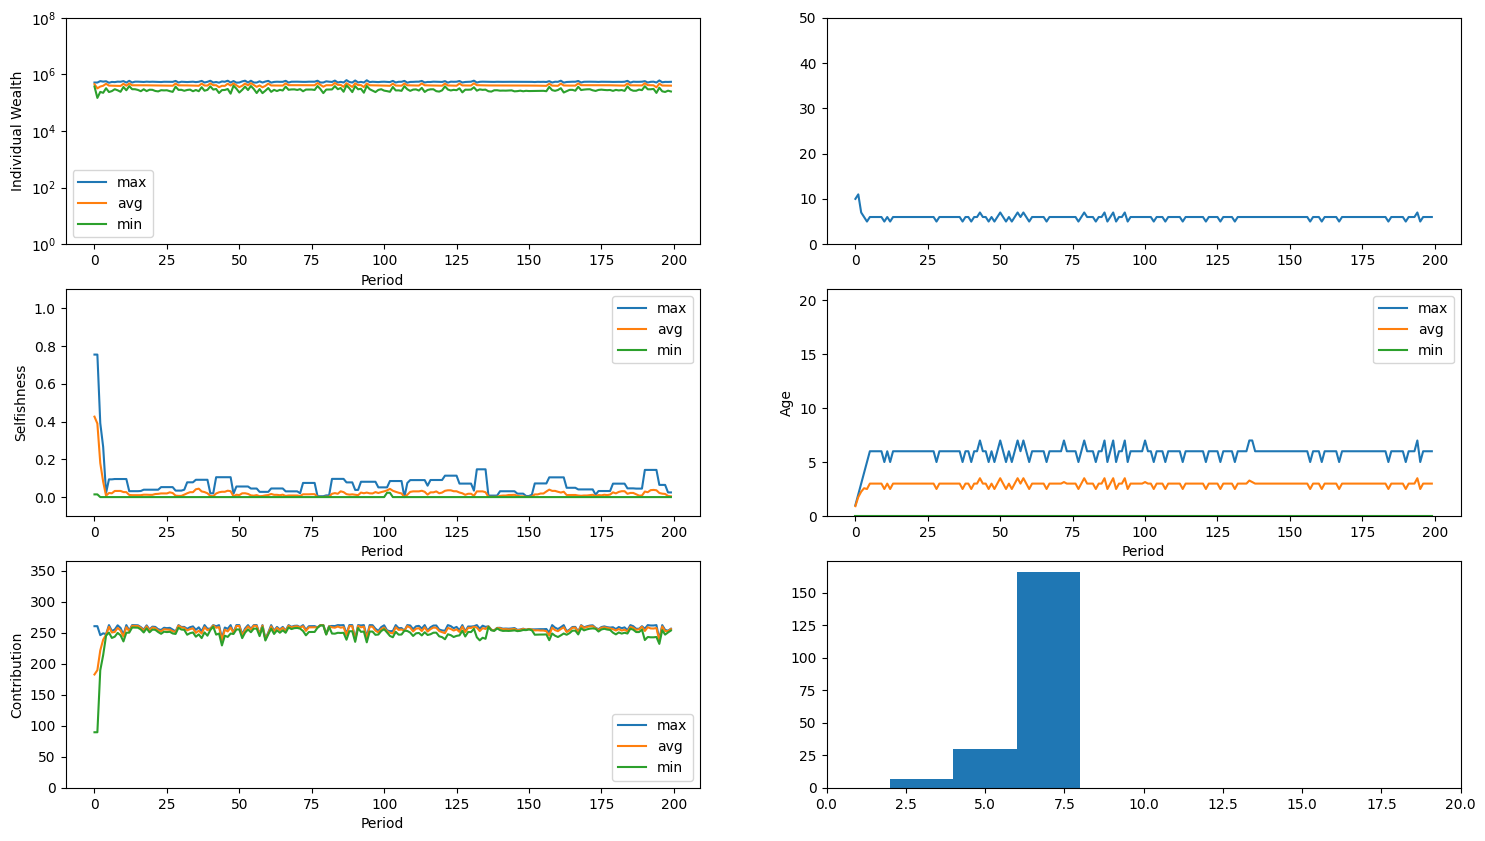

In [5]:
strategy = models.DefaultWorldStrategy(
    reward_distribution_strategy=models.EqualContribution(),
    recruitment_strategy=recruitment_strategy,
    person_action_strategy=models.person.StrategicSelfishness(),
    identity_generator=id_gen,
)
run_experiment('strategic-selfishness', world_seed, strategy)
plot_run('strategic-selfishness')

#### Conclusions and further questions

Honestly I'm not sure how to interpret these results. Strategic selfishness should work out pretty well for each person, but when I think about it, **I don't really have a clear way of measuring "success" from the individual's perspective.**  What I need to do is find a way to measure that.

In fact, while working on strategic selfishness I came up with the concept of quality of life - the ratio the amount of reward a person has (technically how much they're projected to receive at the end of the fiscal period) and the fiscal cost of living. Lower than 1 means the person is about to die, whereas higher than 1 means the person is saving up. Maybe I could use this a measure of success?

Some other ideas:
- I should measure more data for each individual person. Things like how much they contributed each day, how much bonus they received, how they decided to make their contribution etc. This will probably turn out to be quite computationally intensive, so I might have to do some performance optimizations as well.
- I should probably write this journal in Jupyter notebooks. That way it will be easier and more natural to visualize the data/express how it was visualized.
- I think I'm at the stage where I can start implementing some "AI" for each person. I can sort-of imagine how I would go about implementing simple neural networks, and how I could "breed" them during the recruitment process.
